<a href="https://colab.research.google.com/github/Max-Wind0/Tree-classification-and-Ensemble-classification/blob/main/Tree_classification_and_Ensemble_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Разработайте программу, которая выполняет классификацию заданного набора данных с помощью дерева решений. Параметрами программы являются набор данных, критерий выбора атрибута разбиения (Information gain, Gain ratio, Gini index).

\
2. Проведите эксперименты на наборе Census Income (данные о результатах переписи населения, в т.ч. о годовом доходе -- ниже или выше $50000). В качестве обучающей выборки для построения дерева используйте 100% исходных данных.

\
3. Выполните визуализацию построенных деревьев решений.

\
4. Доработайте программу, добавив в список ее параметров долю, которую занимает обучающая выборка от общего размера набора данных, и обеспечив вычисление и выдачу в качестве результатов следующих показателей качества классификации: аккуратность (accuracy), точность (precision), полнота (recall), F-мера.

5. Проведите эксперименты на наборе данных, фиксируя критерий выбора атрибута разбиения и варьируя соотношение мощностей обучающей и тестовой выборок от 60%:40% до 90%:10% с шагом 10%.

\
6. Выполните визуализацию полученных результатов в виде следующих диаграмм:
построенные деревья решений для заданного набора данных;
показатели качества классификации в зависимости от соотношения мощностей обучающей и тестовой выборок для заданного набора данных.

\
7. Подготовьте отчет о выполнении задания и загрузите отчет в формате PDF в систему. Отчет должен представлять собой связный и структурированный документ со следующими разделами:  
* формулировка задания;
* гиперссылка на каталог репозитория с исходными текстами, наборами данных и др. сопутствующими материалами;
* рисунки с результатами визуализации;
* пояснения, раскрывающие смысл полученных результатов.

Импорт необходимых библиотек для выполнения поставленных задач

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Данные загружаются из txt-файлов adult.data.txt и adult.test.txt, которые представляют собой некоторые параметры человека, такие как его возраст, рабочий класс, образование и т.д. Главным результирующим параметром является степень дохода, в сравнении с 50000 долларов, больше ли эта или нет.

In [42]:
train_file = '/content/drive/MyDrive/ДАТАСЕТЫ/adult.data.txt'
test_file = '/content/drive/MyDrive/ДАТАСЕТЫ/adult.test.txt'

train_data = pd.read_csv(train_file, header=None, sep='\s+')
test_data = pd.read_csv(test_file, header=None, sep='\s+')

train_data.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
test_data.columns = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
train_data.head()

age          workclass   fnlwgt   education education-num  \
0  39,         State-gov,   77516,  Bachelors,           13,   
1  50,  Self-emp-not-inc,   83311,  Bachelors,           13,   
2  38,           Private,  215646,    HS-grad,            9,   
3  53,           Private,  234721,       11th,            7,   
4  28,           Private,  338409,  Bachelors,           13,   

        marital-status          occupation    relationship    race      sex  \
0       Never-married,       Adm-clerical,  Not-in-family,  White,    Male,   
1  Married-civ-spouse,    Exec-managerial,        Husband,  White,    Male,   
2            Divorced,  Handlers-cleaners,  Not-in-family,  White,    Male,   
3  Married-civ-spouse,  Handlers-cleaners,        Husband,  Black,    Male,   
4  Married-civ-spouse,     Prof-specialty,           Wife,  Black,  Female,   

  capital-gain capital-loss hours-per-week  native-country income  
0        2174,           0,            40,  United-States,  <=50K  
1           0,           0,            13,  United-States,  <=50K  
2           0,           0,            40,  United-States,  <=50K  
3           0,           0,            40,  United-States,  <=50K  
4           0,           0,            40,           Cuba,  <=50K

Кодирование текстовых параметров в числовые для дальнейшего обучения модели.

In [43]:
label_encoder = LabelEncoder()
for column in train_data.select_dtypes(include=['object']).columns:
  train_data[column] = label_encoder.fit_transform(train_data[column])
  test_data[column] = label_encoder.fit_transform(test_data[column])
train_data.head()

age  workclass  fnlwgt  education  education-num  marital-status  \
0   22          7   20429          9              4               4   
1   33          6   20691          9              4               2   
2   21          4   10268         11             15               0   
3   36          4   11553          1             13               2   
4   11          4   16170          9              4               2   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           1             1     4    1            33             0   
1           4             0     4    1             0             0   
2           6             1     4    1             0             0   
3           6             0     2    1             0             0   
4          10             5     2    0             0             0   

   hours-per-week  native-country  income  
0              34              39       0  
1               4              39       0  
2              34              39       0  
3              34              39       0  
4              34               5       0

Модель дерева решений с заданным критерием разбиения

In [44]:
def train_and_evaluate_model(train_data, test_data, criterion, train_size=0.8):
    X_train = train_data.drop(columns='income')
    y_train = train_data['income']
    X_test = test_data.drop(columns='income')
    y_test = test_data['income']

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=train_size, random_state=42)

    clf = DecisionTreeClassifier(criterion=criterion, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    plt.figure(figsize=(20, 10))
    plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['<=50K', '>50K'], rounded=True)
    plt.show()

    return accuracy, precision, recall, f1

Создается модель дерева решений с заданным критерием разбиения (gini или entropy), производится обучение и прогнозирование, затем рассчитываются метрики качества: accuracy, precision, recall и F1.

Критерий разбиения: gini


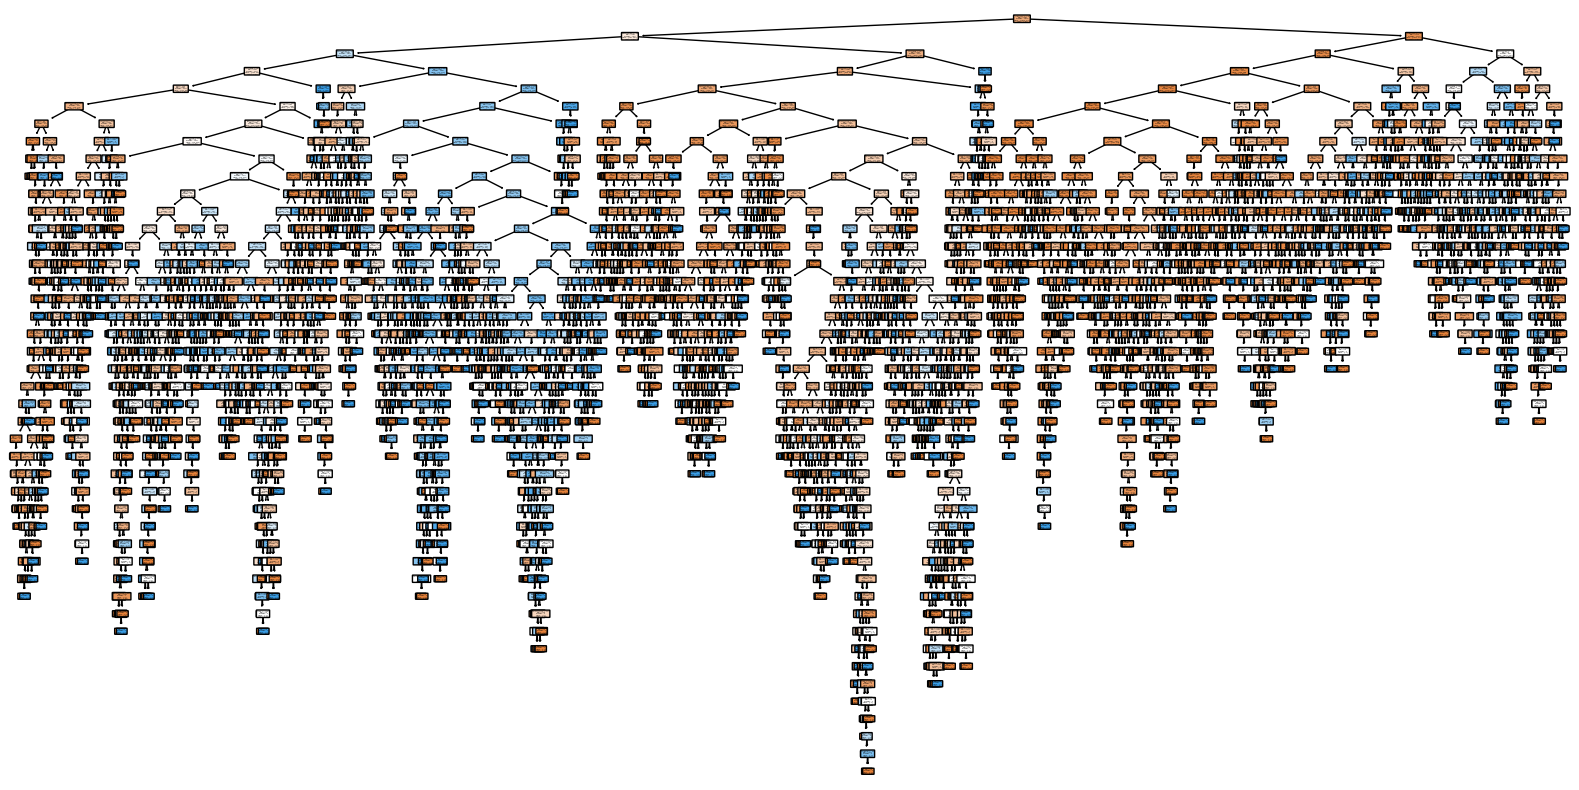

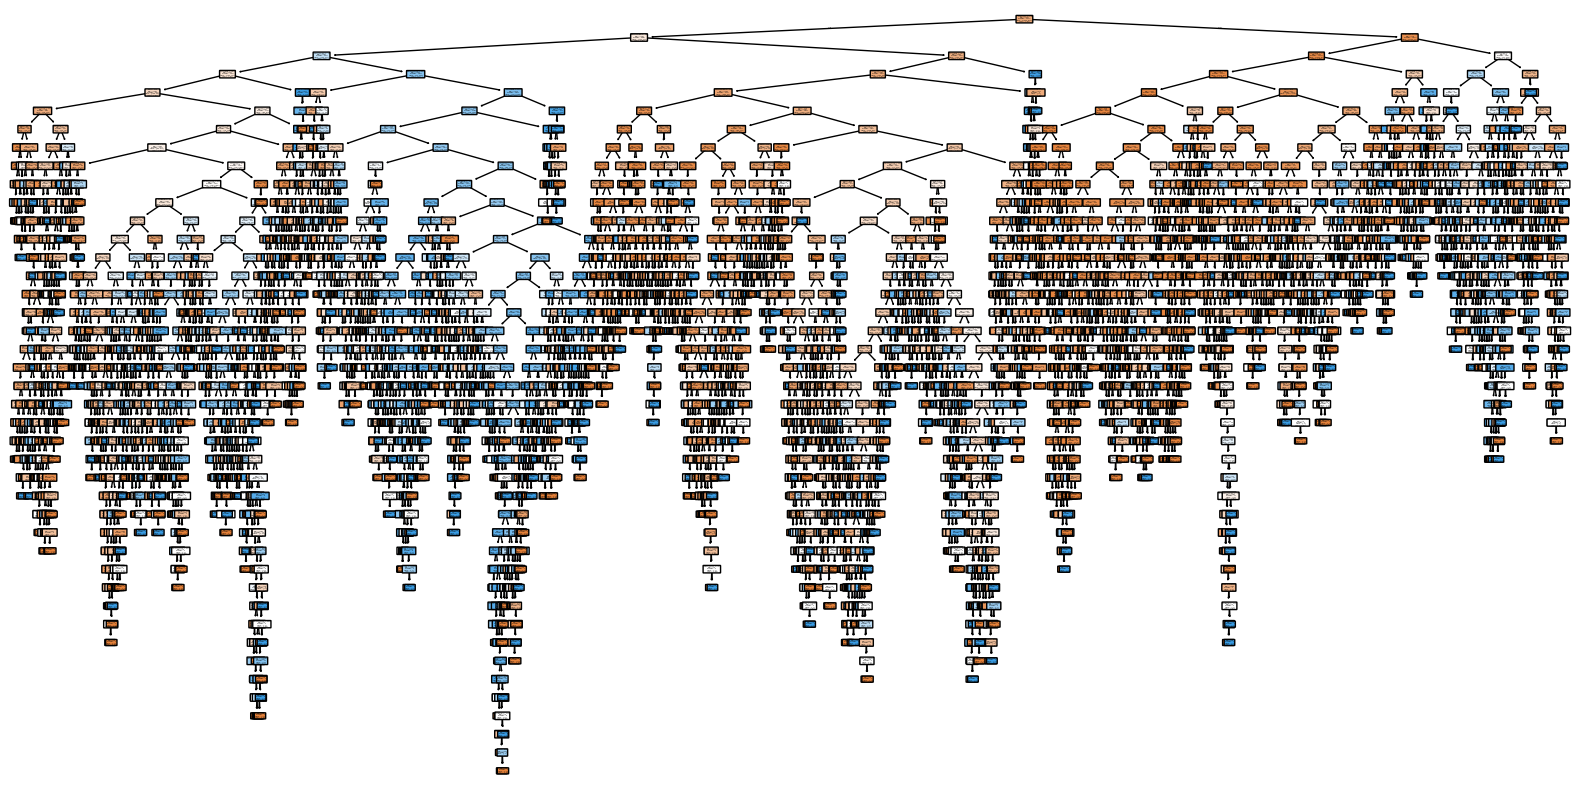

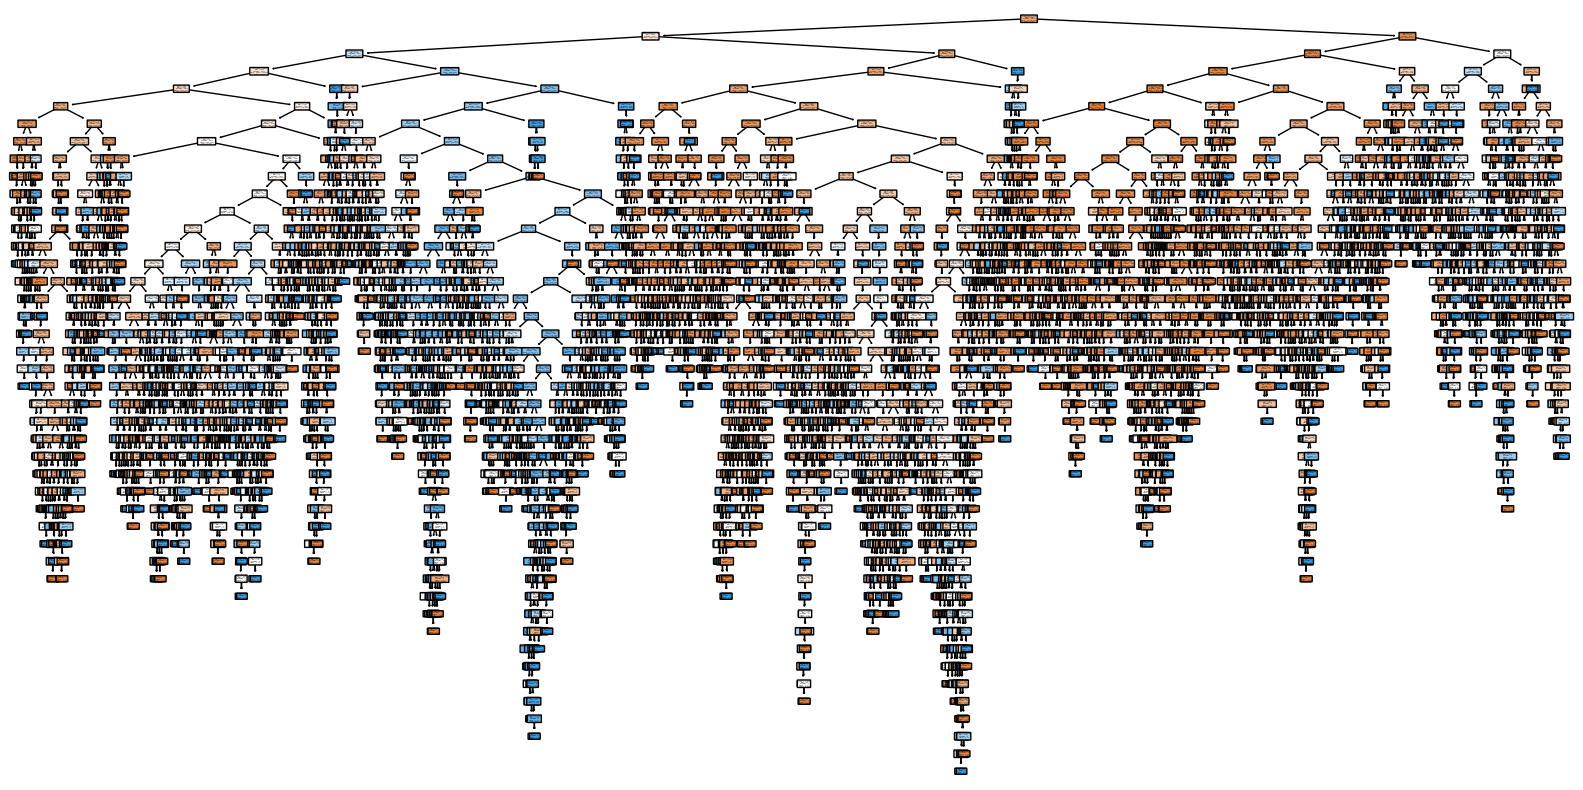

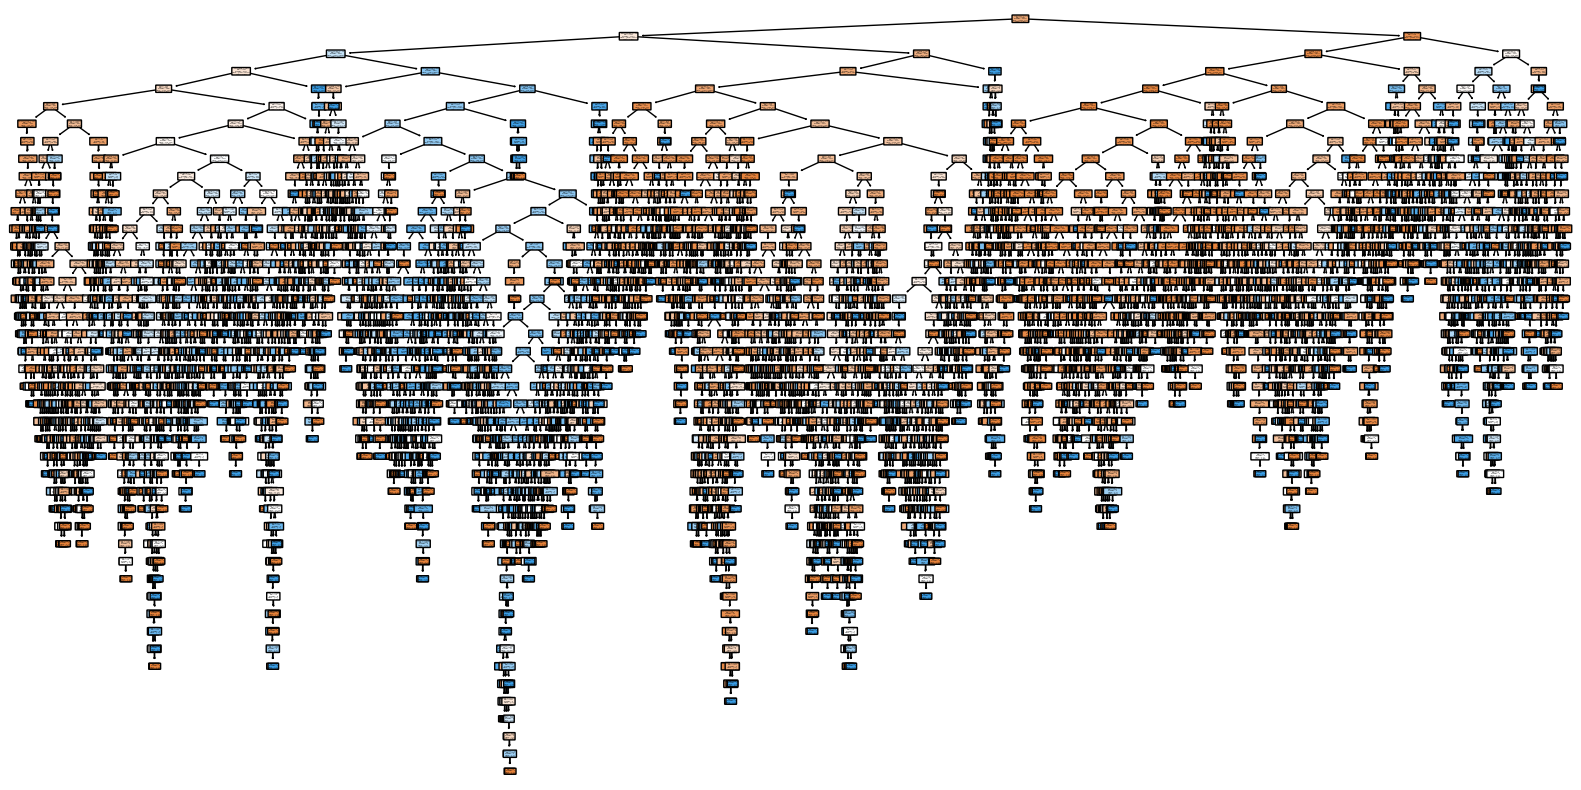

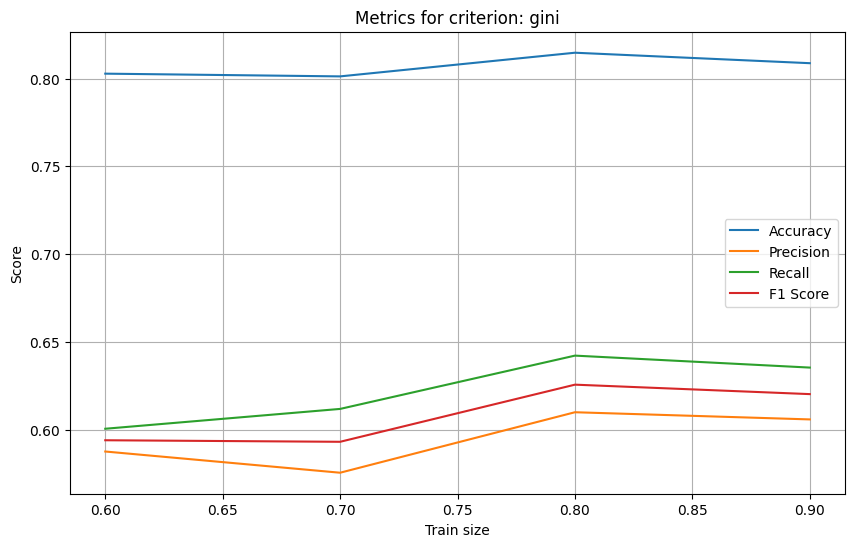

Критерий разбиения: entropy


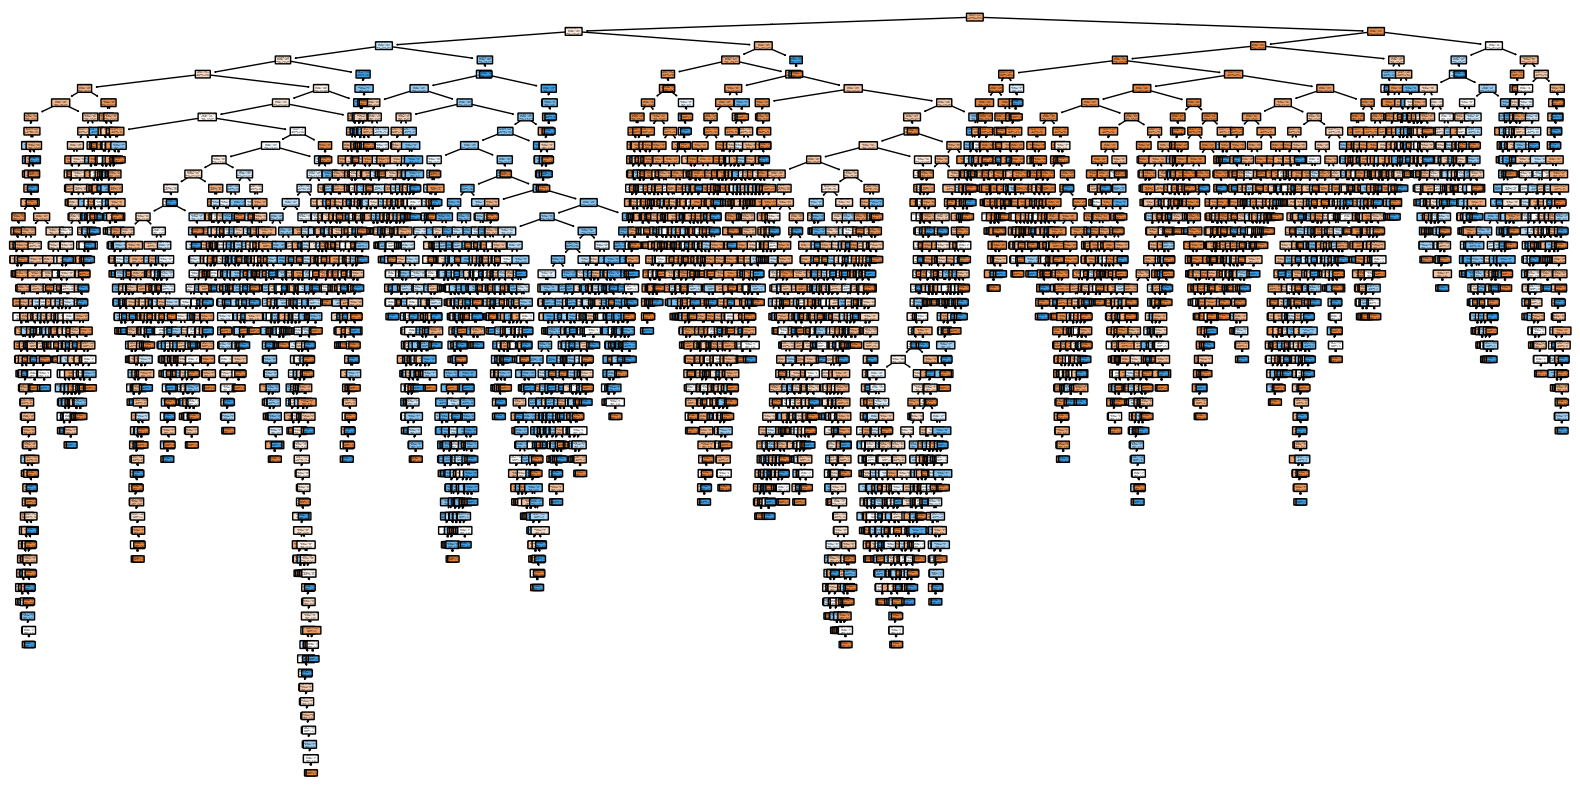

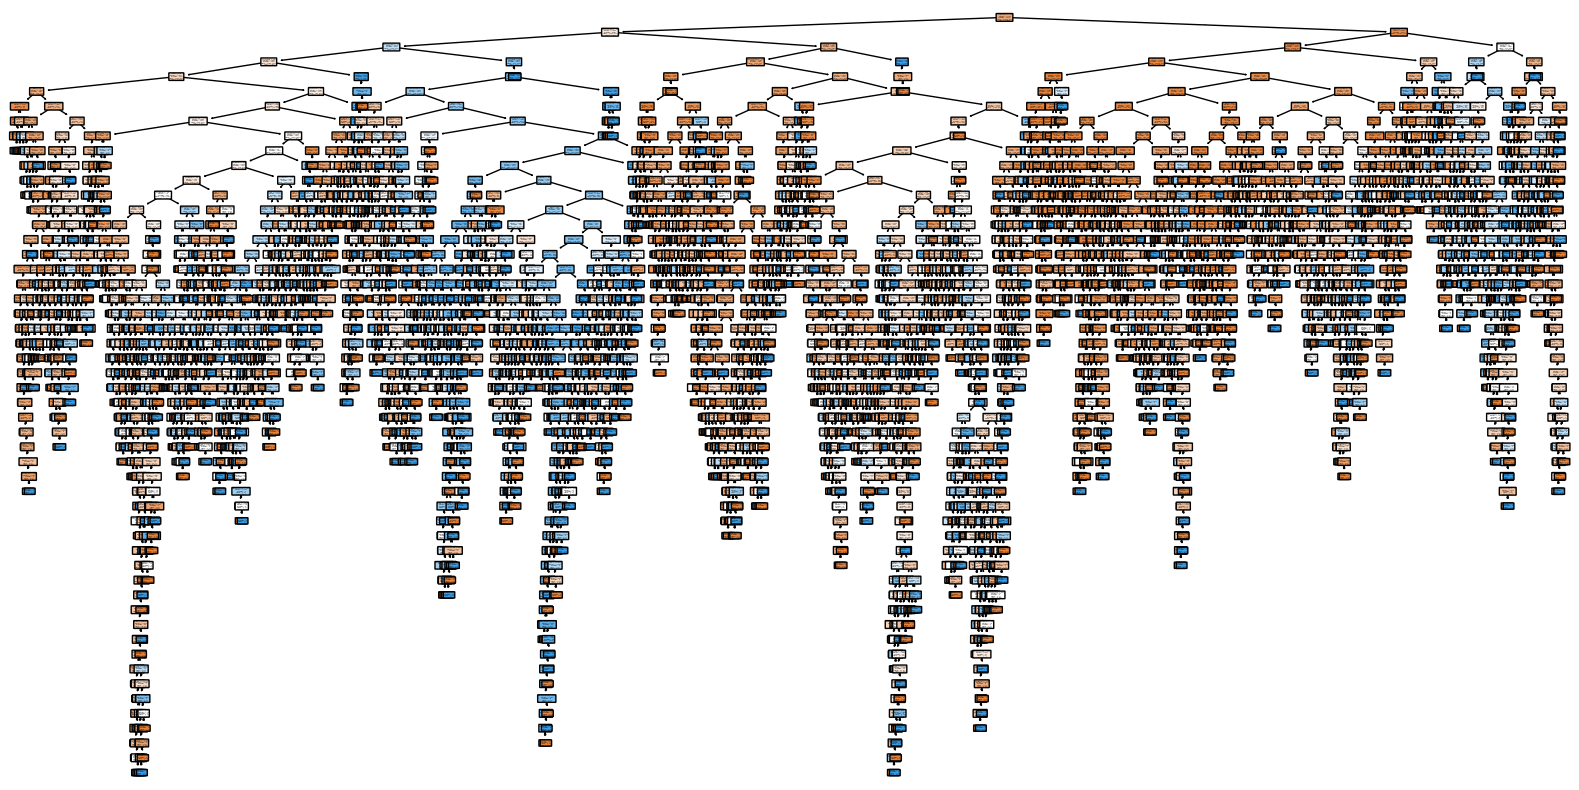

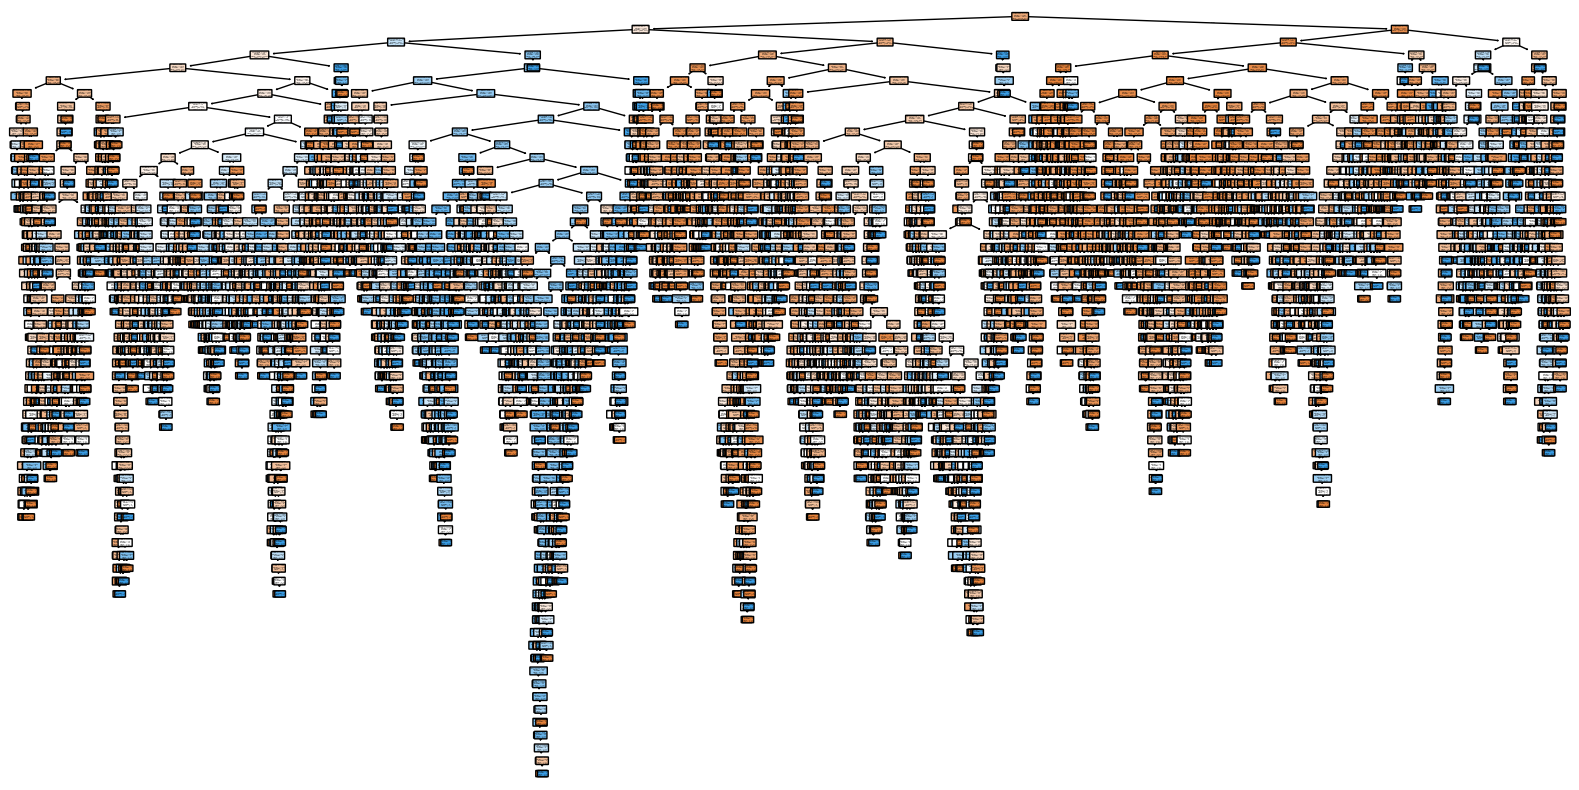

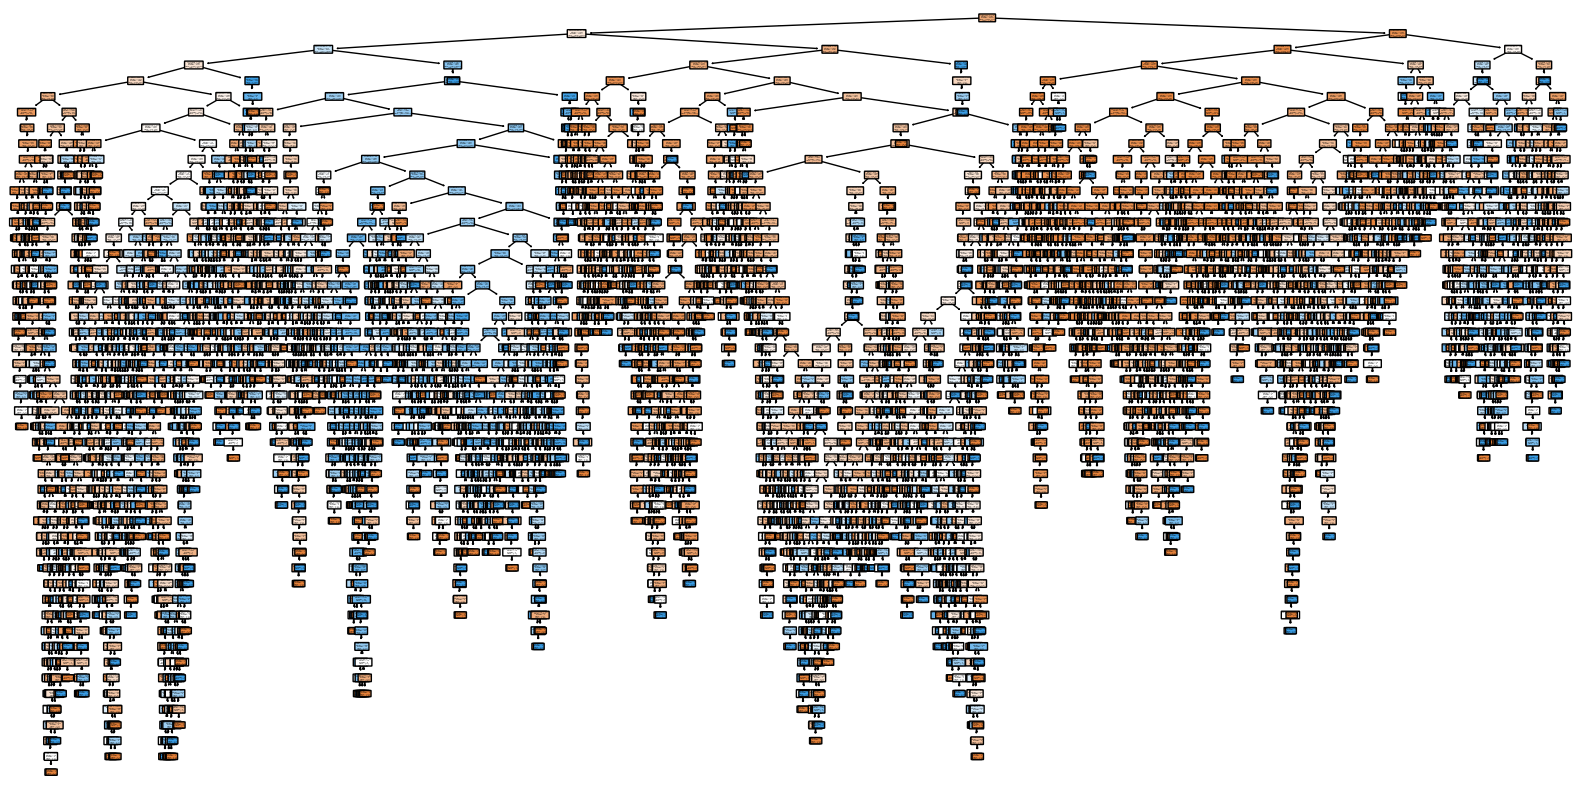

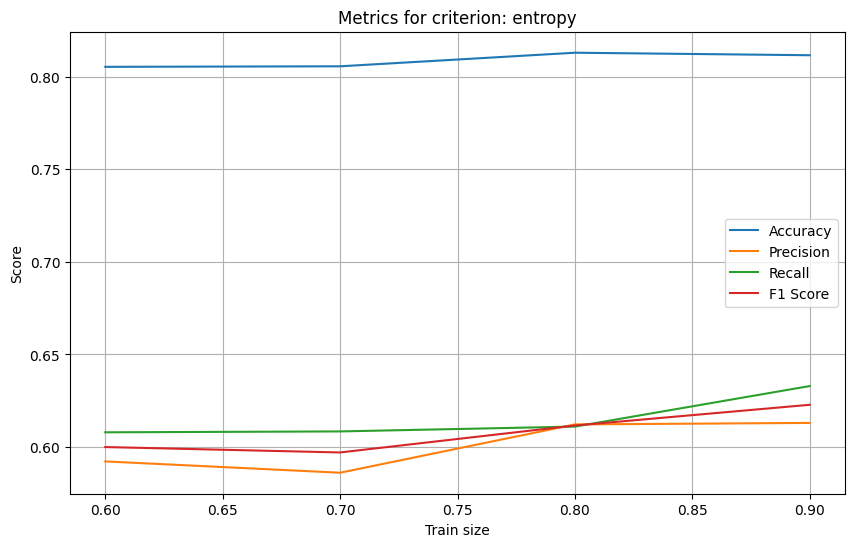

In [45]:
criteria = ['gini', 'entropy']
train_sizes = np.arange(0.6, 1.0, 0.1)

for criterion in criteria:
    print(f"Критерий разбиения: {criterion}")
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for train_size in train_sizes:
        accuracy, precision, recall, f1 = train_and_evaluate_model(train_data, test_data, criterion, train_size)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Визуализация метрик качества
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, accuracies, label='Accuracy')
    plt.plot(train_sizes, precisions, label='Precision')
    plt.plot(train_sizes, recalls, label='Recall')
    plt.plot(train_sizes, f1_scores, label='F1 Score')
    plt.xlabel('Train size')
    plt.ylabel('Score')
    plt.title(f'Metrics for criterion: {criterion}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [46]:
def evaluate_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1

def train_ensemble_and_evaluate(model_class, model_params, X_train, y_train, X_test, y_test, n_estimators_range):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for n_estimators in n_estimators_range:
        model = model_class(n_estimators=n_estimators, random_state=42, **model_params)

        accuracy, precision, recall, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    return accuracies, precisions, recalls, f1_scores

In [57]:
# Подготовка данных
X_train = train_data.drop(columns='income')
y_train = train_data['income']
X_test = test_data.drop(columns='income')
y_test = test_data['income']

# Параметры для модели
n_estimators_range = np.arange(50, 101, 10)

# 1. Бэггинг
bagging_accuracies, bagging_precisions, bagging_recalls, bagging_f1_scores = train_ensemble_and_evaluate(
    BaggingClassifier, {}, X_train, y_train, X_test, y_test, n_estimators_range)

# 2. Случайный лес
rf_accuracies, rf_precisions, rf_recalls, rf_f1_scores = train_ensemble_and_evaluate(
    RandomForestClassifier, {}, X_train, y_train, X_test, y_test, n_estimators_range)

# 3. Градиентный бустинг
gb_accuracies, gb_precisions, gb_recalls, gb_f1_scores = train_ensemble_and_evaluate(
    GradientBoostingClassifier, {'learning_rate': 0.1, 'max_depth': 3}, X_train, y_train, X_test, y_test, n_estimators_range)

# 4. Оценка дерева решений для сравнения
dt_accuracy, _, _, _ = evaluate_model(DecisionTreeClassifier(random_state=42), X_train, y_train, X_test, y_test)


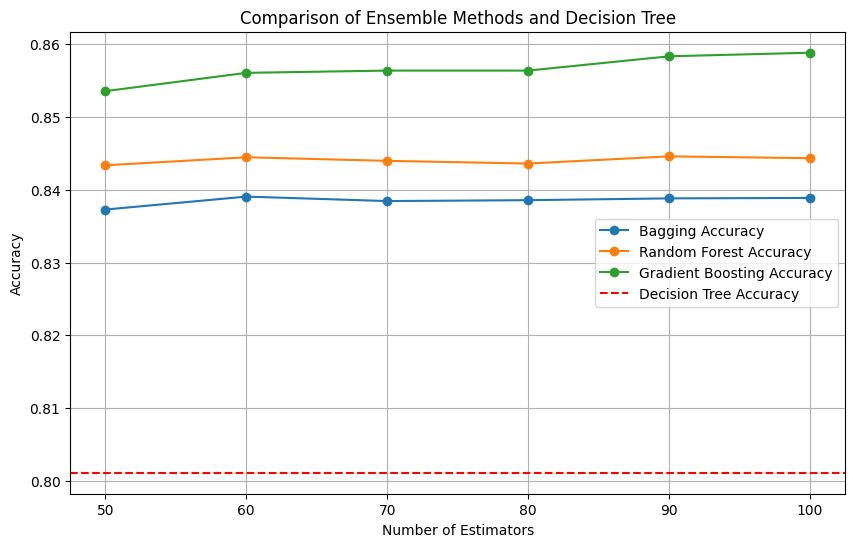

In [58]:
# Визуализация результатов
plt.figure(figsize=(10, 6))

plt.plot(n_estimators_range, bagging_accuracies, label='Bagging Accuracy', marker='o')
plt.plot(n_estimators_range, rf_accuracies, label='Random Forest Accuracy', marker='o')
plt.plot(n_estimators_range, gb_accuracies, label='Gradient Boosting Accuracy', marker='o')
plt.axhline(y=dt_accuracy, color='r', linestyle='--', label='Decision Tree Accuracy')

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Comparison of Ensemble Methods and Decision Tree')
plt.legend()
plt.grid(True)
plt.show()